In [3]:
import Modules.SQcircuit_extensions as sq_ext
import Modules.figures as figs
import SQcircuit as sq
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
import importlib
import scipy as sp

%matplotlib ipympl
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })
plt.rcParams['text.usetex'] = False
importlib.reload(sq_ext)
importlib.reload(sq)
importlib.reload(figs)
np.set_printoptions(linewidth=300, formatter={'float': '{:.12f}'.format})
# np.set_printoptions(linewidth=200, formatter={'float': '{:.1e}'.format})

In [4]:
nH   = 1e-9
fF   = 1e-15
GHz  = 1e9
h    = 6.626e-34
e0   = 1.602e-19
Φ_0  = h/(2*e0)

In [5]:
C, CJ, Csh, Lq, Lr, Δ, EJ = sq_ext.get_experimental_parameters('qubit_1', return_effective=False)
CF, CR = sq_ext.C_CJ_Csh_to_CF_CR_eff(C, CJ, Csh)
LF, LR, LC = sq_ext.Lq_Lr_to_LF_LR_LC_eff(Lq, Lr, Δ)
EL = sq_ext.L_to_EL(LF)
φ_ext=0.5

In [8]:
fluxonium = sq_ext.sq_fluxonium(C_F_eff=CF, L_F_eff=LF, EJ=EJ, φ_ext=φ_ext)
resonator = sq_ext.sq_resonator(C_R_eff=CR, L_R_eff=LR )
fluxonium.diag(4)[0]-fluxonium.diag(2)[0][0] ,resonator.diag(3)[0]

(array([-0.000000000000, 3.688697882073, 8.094751157701, 12.925858049114]),
 array([-0.000000000000, 6.460000000000, 12.919999999999]))

In [10]:
E_f = fluxonium.diag(4)[0]-fluxonium.diag(2)[0][0] 
E_f[1:]-E_f[:-1]

array([3.688697882073, 4.406053275628, 4.831106891413])

In [13]:
ω_r = resonator.diag(3)[0][1]

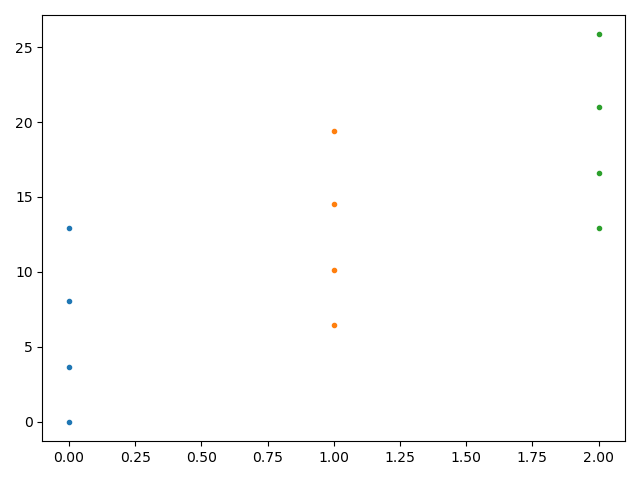

In [16]:
n0 = np.zeros(len(E_f))

fig, ax = plt.subplots()

ax.plot(n0, E_f, '.')
ax.plot(n0+1, E_f+ω_r, '.')
ax.plot(n0+2, E_f+2*ω_r, '.')

fig.tight_layout()
fig.show()

In [12]:
def g_unit_cell(CR, CF, LF, LR, EJ, LC, φ_ext):
    fluxonium = sq_ext.sq_fluxonium(C_F_eff=CF, L_F_eff=LF, EJ=EJ, φ_ext=φ_ext)
    fluxonium.diag(2)
    CR *= fF
    CF *= fF
    LR *= nH
    LF *= nH
    LC *= nH
    Φ_f  = np.real( fluxonium.flux_op(0,'eig')[1,0])  
    Φ_r  = np.sqrt(0.5*np.sqrt(LR/CR))   
    return Φ_f * Φ_r / LC /2/np.pi/GHz

In [28]:
EJ_values = np.geomspace(1e-1,100,100)
φ_ext_values = np.linspace(0,0.5,100)

In [255]:
g_vs_EJ = np.array([g_unit_cell(CR, CF, LF, LR, EJ_i, LC, φ_ext) for EJ_i in EJ_values])
g_vs_φ_ext = np.array([g_unit_cell(CR, CF, LF, LR, EJ, LC, φ_ext_i) for φ_ext_i in φ_ext_values])

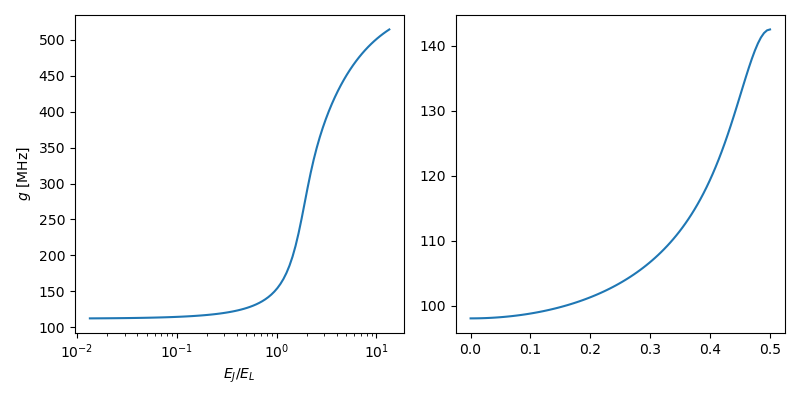

In [256]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize = [8,4])

ax1.plot(EJ_values/EL, g_vs_EJ * 1e3)
ax2.plot(φ_ext_values, g_vs_φ_ext * 1e3)

ax1.set_xlabel('$E_J/E_{L}$')
ax1.set_ylabel('$g$ [MHz]')
ax1.set_xscale('log')
fig.tight_layout()
fig.show()

In [52]:
EJ_values = np.geomspace(1e-1,100,100)
φ_ext_values = np.linspace(0,0.5,99)
g_vs_EJ_φ_ext = np.zeros([len(EJ_values), len(φ_ext_values)])
for i, EJ_i in enumerate(EJ_values):
    for j, φ_ext_j in enumerate(φ_ext_values):
        g_vs_EJ_φ_ext[i,j] = g_unit_cell(CR, CF, LF, LR, EJ_i, LC, φ_ext_j) 

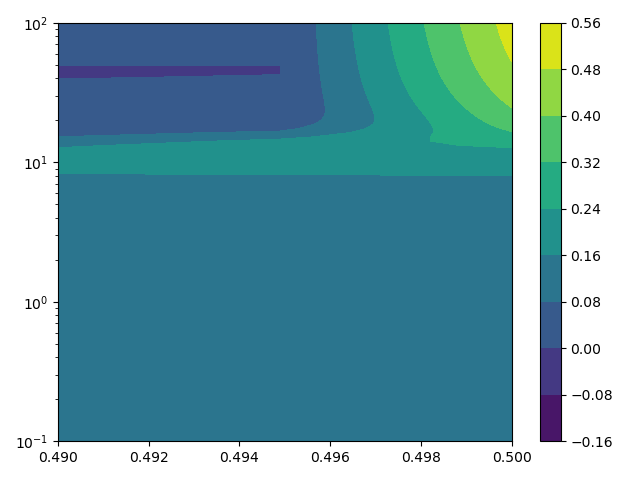

In [66]:
fig, ax = plt.subplots()

cf = ax.contourf(φ_ext_values, EJ_values, g_vs_EJ_φ_ext )

# figs.colorbar(cf)
ax.set_xlim([0.49,0.5])
ax.set_yscale('log')
fig.colorbar(cf)
fig.tight_layout()
fig.show()


In [234]:
def g_with_ops_unit_cell(CR, CF, LF, LR, EJ, LC, φ_ext):
    fluxonium = sq_ext.sq_fluxonium(C_F_eff=CF, L_F_eff=LF, EJ=EJ, φ_ext=φ_ext)
    E = fluxonium.diag(2)[0]
    
    CR *= fF
    CF *= fF
    LR *= nH
    LF *= nH
    LC *= nH
    Φ_f  = fluxonium.flux_op(0,'eig').__array__()[:2,:2]
    Φ_r  = np.sqrt(0.5*np.sqrt(LR/CR))  
    
    P = sq_ext.decomposition_in_pauli_2x2(Φ_f)
    
    return P * Φ_r / LC /2/np.pi/GHz, E[1:]-E[0]

In [235]:
φ_ext_values = np.linspace(0,0.5,100)

In [277]:
g_ops_vs_φ_ext_EJ1 = np.zeros([len(φ_ext_values),4])
g_ops_vs_φ_ext_EJ2 = np.zeros([len(φ_ext_values),4])
E_vs_φ_ext = np.zeros([len(φ_ext_values),1])
for i, φ_ext_i in enumerate(φ_ext_values):
    g_ops_vs_φ_ext_EJ1[i], E_vs_φ_ext[i] =  g_with_ops_unit_cell(CR, CF, LF, LR, EL, LC, φ_ext_i) 
    g_ops_vs_φ_ext_EJ2[i], E_vs_φ_ext[i] =  g_with_ops_unit_cell(CR, CF, LF, LR, EL/10, LC, φ_ext_i) 

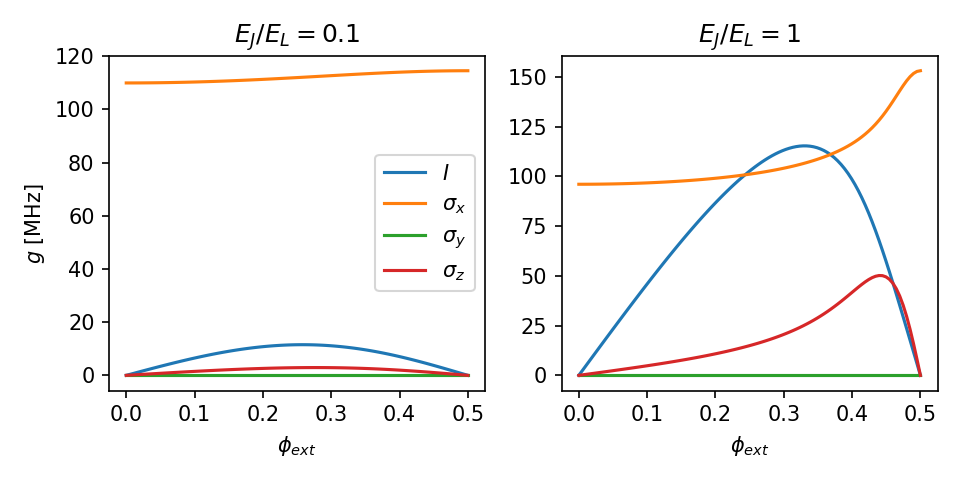

In [282]:
labels = ['$I$', '$\sigma_x$', '$\sigma_y$', '$\sigma_z$']

fig, (ax2,ax1)= plt.subplots(ncols=2, dpi=150, figsize = np.array([8,4])*0.8 )

for i, label in enumerate(labels):
    ax2.plot(φ_ext_values, g_ops_vs_φ_ext_EJ2[:,i]  * 1e3, label=label )

for i, label in enumerate(labels):
    ax1.plot(φ_ext_values, g_ops_vs_φ_ext_EJ1[:,i]  * 1e3)
    
ax2.legend()
ax2.set_xlabel('$\phi_{ext}$')
ax1.set_xlabel('$\phi_{ext}$')
ax2.set_ylabel('$g$ [MHz]')

ax1.set_title(rf'$E_J/E_L=1$')
ax2.set_title(rf'$E_J/E_L=0.1$')


fig.tight_layout()
figs.export('g_opts_vs_phi_ext.pdf', fig)
fig.show()